In [2]:
import os
import sys
import re
import random
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import *

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from time import time

sqlContext = SQLContext(sc)
base = "/datasets/lastfm/"

In [8]:
userArtistDataSchema  = StructType([ \
    StructField("userID", LongType(), True), \
    StructField("artistID", LongType(), True), \
    StructField("playCount", IntegerType(), True)])

In [10]:
userArtistDF = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .options(header='false', delimiter=' ') \
    .load("user_artist_data.txt", schema = userArtistDataSchema) \
    .cache()

In [11]:
userArtistDF.cache()

DataFrame[userID: bigint, artistID: bigint, playCount: int]

In [13]:
userArtistDF.show()

+-------+--------+---------+
| userID|artistID|playCount|
+-------+--------+---------+
|1000002|       1|       55|
|1000002| 1000006|       33|
|1000002| 1000007|        8|
|1000002| 1000009|      144|
|1000002| 1000010|      314|
|1000002| 1000013|        8|
|1000002| 1000014|       42|
|1000002| 1000017|       69|
|1000002| 1000024|      329|
|1000002| 1000025|        1|
|1000002| 1000028|       17|
|1000002| 1000031|       47|
|1000002| 1000033|       15|
|1000002| 1000042|        1|
|1000002| 1000045|        1|
|1000002| 1000054|        2|
|1000002| 1000055|       25|
|1000002| 1000056|        4|
|1000002| 1000059|        2|
|1000002| 1000062|       71|
+-------+--------+---------+
only showing top 20 rows



In [14]:
uniqueUsers = userArtistDF.select("userID").distinct().count()
print("Total n. of users: ", uniqueUsers)

Total n. of users:  148111


In [16]:
uniqueArtists  = userArtistDF.select("artistID").distinct().count()
print("Total n. of artists: ", uniqueArtists)

Total n. of artists:  1631028


In [19]:
userArtistDF.describe().show()

+-------+------------------+------------------+------------------+
|summary|            userID|          artistID|         playCount|
+-------+------------------+------------------+------------------+
|  count|          24296858|          24296858|          24296858|
|   mean|1947573.2653533637|1718704.0937568964| 15.29576248089362|
| stddev| 496000.5551820078|2539389.0924284607|153.91532446979554|
|    min|                90|                 1|                 1|
|    max|           2443548|          10794401|            439771|
+-------+------------------+------------------+------------------+



In [21]:
# Compute user activity# Compu 
# We are interested in how many playcounts each user has scored.
userActivity = userArtistDF.groupBy("userID").sum("playCount").collect()
userActivity[0:5]

[Row(userID=1000061, sum(playCount)=244),
 Row(userID=1000070, sum(playCount)=20200),
 Row(userID=1000313, sum(playCount)=201),
 Row(userID=1000832, sum(playCount)=1064),
 Row(userID=1000905, sum(playCount)=214)]

[     0      1      2 ..., 148108 148109 148110]


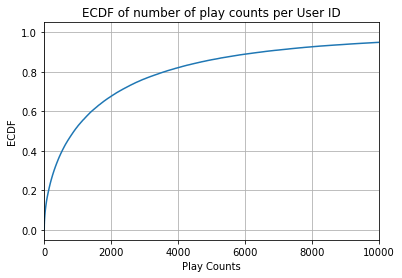

In [23]:
pdf = pd.DataFrame(data=userActivity)
Y=np.sort( pdf[1] )
yvals=np.arange(len(Y))/float(len(Y))

print(np.arange(len(Y)))

plt.plot( Y, yvals )
plt.xlabel('Play Counts')
plt.xlim(0,10000)   # We shrink the window 
plt.ylabel('ECDF')
plt.grid(True,which="both",ls="-")
plt.title('ECDF of number of play counts per User ID')
plt.show()

In [25]:
# Additional relevant code
percentiles = [0.03, 0.10, 0.25, 0.50, 0.75, 0.90]
for p in percentiles:
    i = np.where(yvals<=p)[0][-1]    
    print(str(p*100),"percent of the users has less than: ",Y[i]," play counts")

3.0 percent of the users has less than:  4  play counts
10.0 percent of the users has less than:  34  play counts
25.0 percent of the users has less than:  204  play counts
50.0 percent of the users has less than:  892  play counts
75.0 percent of the users has less than:  2800  play counts
90.0 percent of the users has less than:  6484  play counts


In [27]:
# Compute artist popularity
# We are interested in how many playcounts per artist
# ATTENTION! Grouping by artistID may be problematic, as stated above.

artistPopularity = userArtistDF.groupby("artistID").sum("playCount").collect()

[      0       1       2 ..., 1631025 1631026 1631027]


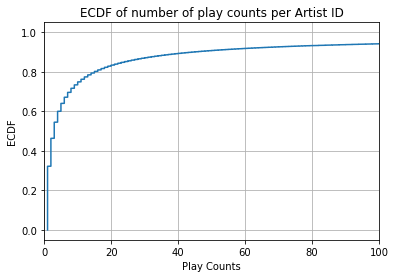

In [28]:
pdf = pd.DataFrame(data=artistPopularity)
Y=np.sort( pdf[1] )
yvals=np.arange(len(Y))/float(len(Y))

print(np.arange(len(Y)))

plt.plot( Y, yvals )
plt.xlabel('Play Counts')
plt.xlim(0,100)
plt.ylabel('ECDF')
plt.grid(True,which="both",ls="-")
plt.title('ECDF of number of play counts per Artist ID')
plt.show()

In [29]:
# Additional relevant code
percentiles = [0.25, 0.50, 0.75, 0.90, 0.95, 0.99]
for p in percentiles:
    i = np.where(yvals<=p)[0][-1]    
    print(str(p*100),"percent of the artists has less than: ",Y[i]," play counts")

25.0 percent of the artists has less than:  1  play counts
50.0 percent of the artists has less than:  3  play counts
75.0 percent of the artists has less than:  11  play counts
90.0 percent of the artists has less than:  45  play counts
95.0 percent of the artists has less than:  126  play counts
99.0 percent of the artists has less than:  1402  play counts


In [38]:
# Additional relevant code# Additi 
artistPopularityCounts = userArtistDF.groupBy("artistID").\
                    sum("playCount").orderBy("sum(playCount)").rdd.map(lambda r:r[1]).collect()

In [40]:
for i in range(1,len(artistPopularityCounts)):
    artistPopularityCounts[i] += artistPopularityCounts[i-1]
artistPopularityCountsReversed = list(reversed(artistPopularityCounts))
pdf = pd.DataFrame(data=artistPopularityCountsReversed)
Y=pdf[0]
yvals=np.arange(len(Y))/float(len(Y))

print(np.arange(len(Y)))

[      0       1       2 ..., 1631025 1631026 1631027]


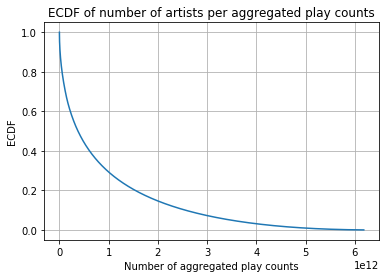

In [41]:
plt.plot(Y, yvals )
plt.xlabel('Number of aggregated play counts')
plt.ylabel('ECDF')
plt.grid(True,which="both",ls="-")
plt.title('ECDF of number of artists per aggregated play counts')
plt.show()

In [42]:
# Additional relevant code
# We keep in mind that many artistID are mispelled
pdf = pd.DataFrame(data=artistPopularityCounts)
Y=pdf[0]
playCountsTotal = userArtistDF.groupBy().sum("playCount").collect()[0][0]
print("Total n. of play counts: ", "{:,}".format(playCountsTotal))
      
percentiles = [0.25, 0.50, 0.750, 0.900, 0.950, 0.990]
for p in percentiles:
    i = np.where(yvals<=p)[0][-1]
    print(str(p*100),"percent of the artists account for: ","{:,}".format(Y[i])," play counts")
    print("-->The top ",str(int((1-p)*100)),"percent of the artists account for: ","{:,}".\
          format(playCountsTotal-Y[i])," play counts")
    print("-->The top ",str(int((1-p)*100)),"percent of the artists account for: ", \
          (playCountsTotal-Y[i])/playCountsTotal*100," percent of the play counts")
    print()

Total n. of play counts:  371,638,969
25.0 percent of the artists account for:  83,133,497,161  play counts
-->The top  75 percent of the artists account for:  -82,761,858,192  play counts
-->The top  75 percent of the artists account for:  -22269.4241174  percent of the play counts

50.0 percent of the artists account for:  376,553,537,377  play counts
-->The top  50 percent of the artists account for:  -376,181,898,408  play counts
-->The top  50 percent of the artists account for:  -101222.403942  percent of the play counts

75.0 percent of the artists account for:  1,217,762,585,795  play counts
-->The top  25 percent of the artists account for:  -1,217,390,946,826  play counts
-->The top  25 percent of the artists account for:  -327573.545396  percent of the play counts

90.0 percent of the artists account for:  2,555,741,265,462  play counts
-->The top  9 percent of the artists account for:  -2,555,369,626,493  play counts
-->The top  9 percent of the artists account for:  -68759

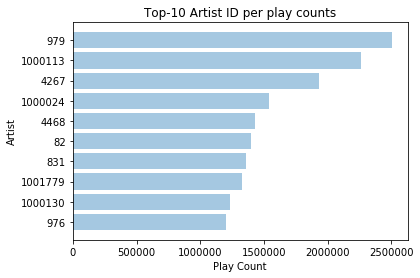

In [45]:

sortedArtist  = sorted(artistPopularity, key = lambda x: -x[1])[: 10]

artistID = [w[0] for w in sortedArtist]

y_pos = range(len(sortedArtist))
frequency = [w[1] for w in sortedArtist]

plt.barh(y_pos, frequency[::-1], align='center', alpha=0.4)
plt.yticks(y_pos, artistID[::-1])
plt.xlabel('Play Count')
plt.ylabel('Artist')
plt.title('Top-10 Artist ID per play counts')
plt.show()

In [46]:

# Additional relevant code# Additi 
print("Total n. of users: ", uniqueUsers)
print("Total n. of artists: ", uniqueArtists)
print("Total play counts: ", "{:,}".format(playCountsTotal))

print("Mean play counts per user: ", playCountsTotal/uniqueUsers)
print("Mean play counts per artist: ", playCountsTotal/uniqueArtists)

Total n. of users:  148111
Total n. of artists:  1631028
Total play counts:  371,638,969
Mean play counts per user:  2509.1922206993404
Mean play counts per artist:  227.85566464830768


In [48]:
customSchemaArtist = StructType([ \
    StructField("artistID", LongType(), True), \
    StructField("name", StringType(), True)])

artistDF = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .options(header='false', delimiter='\t', mode='DROPMALFORMED') \
    .load("artist_data.txt", schema = customSchemaArtist) \
    .cache()
    
artistDF.show(5)

+--------+--------------------+
|artistID|                name|
+--------+--------------------+
| 1134999|        06Crazy Life|
| 6821360|        Pang Nakarin|
|10113088|Terfel, Bartoli- ...|
|10151459| The Flaming Sidebur|
| 6826647|   Bodenstandig 3000|
+--------+--------------------+
only showing top 5 rows



In [49]:
# get artists whose name contains "Aerosmith"
artistDF[locate("Aerosmith", artistDF.name) > 0].show(20,False)

# show two examples
artistDF[artistDF.artistID==1000010].show()
artistDF[artistDF.artistID==2082323].show()


+--------+----------------------------------------------+
|artistID|name                                          |
+--------+----------------------------------------------+
|10586006|Dusty Springfield/Aerosmith                   |
|6946007 |Aerosmith/RunDMC                              |
|10475683|Aerosmith: Just Push Play                     |
|1083031 |Aerosmith/ G n R                              |
|6872848 |Britney, Nsync, Nelly, Aerosmith,Mary J Blige.|
|10586963|Green Day - Oasis - Eminem - Aerosmith        |
|10028830|The Aerosmith Antology2                       |
|10300357|Run-DMC + Aerosmith                           |
|2027746 |Aerosmith by MusicInter.com                   |
|1140418 |[rap]Run DMC and Aerosmith                    |
|10237208|Aerosmith + Run DMC                           |
|10588537|Aerosmith, Kid Rock, & Run DMC                |
|9934757 |Aerosmith - Big Ones                          |
|10437510|Green Day ft. Oasis & Aerosmith               |
|6936680 |RUN 

Artist rank  1  : Radiohead
Artist rank  2  : The Beatles
Artist rank  3  : Green Day
Artist rank  4  : Metallica
Artist rank  5  : System of a Down
Artist rank  6  : Pink Floyd
Artist rank  7  : Nine Inch Nails
Artist rank  8  : Modest Mouse
Artist rank  9  : Bright Eyes
Artist rank  10  : Nirvana


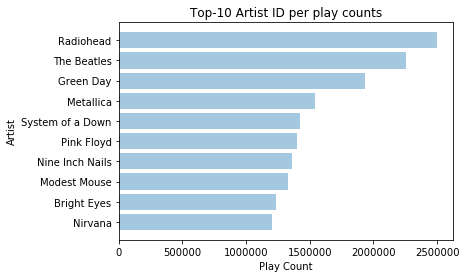

In [50]:

# Additional infos, see who are the top-10 artist names# Additi 
artistNames = []
for (i,artistID) in enumerate([s[0] for s in sortedArtist[0:10]]):
    artistNames.append(artistDF[artistDF.artistID==artistID].collect()[0][1])
    print("Artist rank ", i+1, " :", artistNames[i])
sortedArtist = sorted(artistPopularity, key = lambda x: -x[1])[: 10]

artistID = [w[0] for w in sortedArtist]

y_pos = range(len(sortedArtist))
frequency = [w[1] for w in sortedArtist]

plt.barh(y_pos, frequency[::-1], align='center', alpha=0.4)
plt.yticks(y_pos, artistNames[::-1])
plt.xlabel('Play Count')
plt.ylabel('Artist')
plt.title('Top-10 Artist ID per play counts')
plt.show()

In [52]:
customSchemaArtistAlias = StructType([ \
    StructField("mispelledID", LongType(), True), \
    StructField("standardID",LongType(), True)])

artistAliasDF = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .options(header='false', delimiter='\t', mode='DROPMALFORMED') \
    .load("artist_alias.txt", schema = customSchemaArtistAlias) \
    .cache()

artistAliasDF.show(5)

+-----------+----------+
|mispelledID|standardID|
+-----------+----------+
|    1092764|   1000311|
|    1095122|   1000557|
|    6708070|   1007267|
|   10088054|   1042317|
|    1195917|   1042317|
+-----------+----------+
only showing top 5 rows



In [53]:
artistAliasDF[artistAliasDF.mispelledID==1000010].show()
artistAliasDF[artistAliasDF.mispelledID==2082323].show()

# 1000010 is a standard id, so it haven't been considered as mispelled id in the dataset

+-----------+----------+
|mispelledID|standardID|
+-----------+----------+
+-----------+----------+

+-----------+----------+
|mispelledID|standardID|
+-----------+----------+
|    2082323|   1000010|
+-----------+----------+



In [55]:
def  is_standard (id1):
    """Return True is the ID is not in the mispelledID column of artistAliasDF"""
    if artistAliasDF[artistAliasDF.mispelledID==id1].collect()==[]:
        return True
    else:
        return False

In [56]:
name1 = "Green Day - Oasis - Eminem - Aerosmith"
id1 = artistDF[artistDF.name==name1].first().artistID
is_standard(id1)

True

In [60]:
print(userArtistDF [userArtistDF.artistID==id1].count(), " user(s) listen to ", name1)

1  user(s) listen to  Green Day - Oasis - Eminem - Aerosmith


In [61]:
userArtistDF[userArtistDF.artistID==id1].collect()
strangeUserID=userArtistDF[userArtistDF.artistID==id1].first().userID
strangeUserActivity = userArtistDF[userArtistDF.userID==strangeUserID]
strangeUserActivityWithNames = strangeUserActivity.join(artistDF, on="artistID")
strangeUserActivityWithNames[locate("Aerosmith", strangeUserActivityWithNames.name)>0].show(truncate=False)
strangeUserActivityWithNames[locate("Green Day", strangeUserActivityWithNames.name)>0].show(truncate=False)
strangeUserActivityWithNames[locate("Oasis", strangeUserActivityWithNames.name)>0].show(truncate=False)
strangeUserActivityWithNames[locate("Eminem", strangeUserActivityWithNames.name)>0].show(truncate=False)


+--------+-------+---------+--------------------------------------+
|artistID|userID |playCount|name                                  |
+--------+-------+---------+--------------------------------------+
|10586963|2359019|2        |Green Day - Oasis - Eminem - Aerosmith|
|1000010 |2359019|1        |Aerosmith                             |
+--------+-------+---------+--------------------------------------+

+--------+-------+---------+--------------------------------------+
|artistID|userID |playCount|name                                  |
+--------+-------+---------+--------------------------------------+
|10586963|2359019|2        |Green Day - Oasis - Eminem - Aerosmith|
|4267    |2359019|49       |Green Day                             |
+--------+-------+---------+--------------------------------------+

+--------+-------+---------+--------------------------------------+
|artistID|userID |playCount|name                                  |
+--------+-------+---------+------------------

In [64]:

artistAlias  = artistAliasDF.rdd.map(lambda row: (row.mispelledID, row.standardID)).collectAsMap()


In [65]:
from time import time
def replaceMispelledIDs (fields):
    finalID = artistAlias.get(fields[1], fields[1])
    return (fields[0], finalID, fields[2])

t0 = time()

newUserArtistDF = sqlContext.createDataFrame(
    userArtistDF.rdd.map(replaceMispelledIDs), 
    userArtistDataSchema
)
newUserArtistDF.show(5)

t1 = time()

print('The script takes %f seconds' %(t1-t0))

+-------+--------+---------+
| userID|artistID|playCount|
+-------+--------+---------+
|1000002|       1|       55|
|1000002| 1000006|       33|
|1000002| 1000007|        8|
|1000002| 1000009|      144|
|1000002| 1000010|      314|
+-------+--------+---------+
only showing top 5 rows

The script takes 0.940874 seconds


In [66]:
# Additional code
def scan_artist(artistID):
    """Print some information about the artist given 
    It shows that several entries (user,artist,) exist in newUserArtistDF
    Example: scan_artist(1000010)"""
    artistNameDF = newUserArtistDF.where(newUserArtistDF.artistID==artistID).cache()
    artist = artistDF[artistDF.artistID==artistID].first()
    mispelled = artistAliasDF[artistAliasDF.standardID==artistID].count()
    artistDF[locate(artist.name, artistDF.name) >0].count()
    if artistNameDF is None or artist is None:
        print("The ID provided is not valid, please provide a valid ID")
        return
    print("Id : ", artist.artistID, "Artist name : ", artist.name)
    print(mispelled, " mispelledIDs are associated to artist ", artist.name)
    print()
    print(artist.name, " appears ", artistNameDF.count(), " times in newUserArtistDF")
    print(artistNameDF.select("userID").distinct().count(), " distinct users listen to ", artist.name)
    print(artistNameDF.groupBy('userID').count().where(col("count")>1).count(), "users listen to ", \
          artist.name, " through a mispelledID")

In [67]:
scan_artist(1000010)

Id :  1000010 Artist name :  Aerosmith
130  mispelledIDs are associated to artist  Aerosmith

Aerosmith  appears  17988  times in newUserArtistDF
17938  distinct users listen to  Aerosmith
46 users listen to  Aerosmith  through a mispelledID


In [68]:
print(artistDF[locate("Aerosmith", artistDF.name) >0].count(), "artist names contain Aerosmith")
print(artistAliasDF[artistAliasDF.standardID==1000010].count(), "mispelledIDs point to Aerosmith")

475 artist names contain Aerosmith
130 mispelledIDs point to Aerosmith


In [69]:
from time import time

bArtistAlias = sc.broadcast(artistAlias)

def replaceMispelledIDs(fields):
    finalID = bArtistAlias.value.get(fields[1], fields[1])
    return (fields[0], finalID, fields[2])

t0 = time()

newUserArtistDF = sqlContext.createDataFrame(
    userArtistDF.rdd.map(replaceMispelledIDs), 
    userArtistDataSchema
)
newUserArtistDF.show(5)
t1 = time()

print('The script takes %f seconds' %(t1-t0))
newUserArtistDF = newUserArtistDF.cache()

+-------+--------+---------+
| userID|artistID|playCount|
+-------+--------+---------+
|1000002|       1|       55|
|1000002| 1000006|       33|
|1000002| 1000007|        8|
|1000002| 1000009|      144|
|1000002| 1000010|      314|
+-------+--------+---------+
only showing top 5 rows

The script takes 0.145453 seconds


In [70]:
uniqueArtists = newUserArtistDF.select("artistID").distinct().count()

print("Total n. of artists: ", uniqueArtists)

Total n. of artists:  1568126


In [72]:
# See which artistID is connected to the most mispelledID
numberOfArtistsMispelled = artistAliasDF.select("standardID").distinct().count()
numberOfMispelled = artistAliasDF.count()

mispelledDF = artistAliasDF.select(col("mispelledID").alias("artistID"))
    
playCountsMispelled = newUserArtistDF.join(mispelledDF, on="artistID").rdd.\
                        map(lambda r: r[2]).reduce(lambda v1,v2: v1+v2)
    
print(numberOfArtistsMispelled, " artists have mispelledIDs associated, \
that is a small portion of the total number of unique artists")

print("These ", numberOfArtistsMispelled, " account for ", numberOfMispelled, " mispelled artists")

print("These mispelled artists account for ", "{:,}".format(playCountsMispelled), " play counts", "that is only ", \
     playCountsMispelled/playCountsTotal*100, " percent of the total play counts")

mispelledArtists = artistAliasDF.groupBy("standardID").count().orderBy("count", ascending=0).collect()

print("The artists that are the most mispelled")
for artist in mispelledArtists[:10]:
    name = artistDF[artistDF.artistID==artist[0]].collect()[0][1]
    print("Artist : ", name," (id: ", artist[0], ") has ", artist[1], " mispelled IDs associated")
    

22478  artists have mispelledIDs associated, that is a small portion of the total number of unique artists
These  22478  account for  193027  mispelled artists
These mispelled artists account for  1,712,122  play counts that is only  0.46069496011329214  percent of the total play counts
The artists that are the most mispelled
Artist :  Metallica  (id:  1000024 ) has  1204  mispelled IDs associated
Artist :  [unknown]  (id:  1034635 ) has  955  mispelled IDs associated
Artist :  Pink Floyd  (id:  82 ) has  671  mispelled IDs associated
Artist :  South Park  (id:  1003694 ) has  656  mispelled IDs associated
Artist :  Linkin Park  (id:  1854 ) has  656  mispelled IDs associated
Artist :  The Beatles  (id:  1000113 ) has  629  mispelled IDs associated
Artist :  Eminem  (id:  930 ) has  628  mispelled IDs associated
Artist :  Radiohead  (id:  979 ) has  620  mispelled IDs associated
Artist :  Iron Maiden  (id:  1000107 ) has  537  mispelled IDs associated
Artist :  Nirvana  (id:  976 ) has

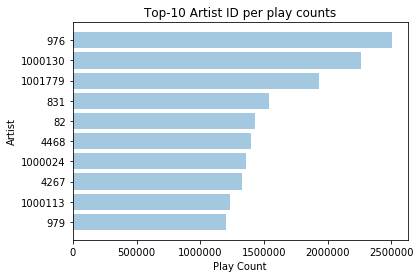

In [73]:
# calculate top-10 artists in term of play counts
top10ArtistsPC = newUserArtistDF.groupBy("artistID").sum("playCount").orderBy('sum(playCount)', ascending=0).take(10)

y_pos = range(len(top10ArtistsPC))
pdf = pd.DataFrame(data=top10ArtistsPC)

plt.barh(y_pos, pdf[1][::-1], align='center', alpha=0.4)
plt.yticks(range(9,-1,-1), pdf[0][::-1])
plt.xlabel('Play Count')
plt.ylabel('Artist')
plt.title('Top-10 Artist ID per play counts')
plt.show()

In [74]:
pdf # sortedArtist after fixing the mispelledIDs

,0,1
0,979,2502596
1,1000113,2259825
2,4267,1931143
3,1000024,1543430
4,4468,1426254
5,82,1399665
6,831,1361977
7,1001779,1328969
8,1000130,1234773
9,976,1203348


In [75]:
sortedArtist # sortedArtist before fixing the mispelledIDs

[Row(artistID=979, sum(playCount)=2502130),
 Row(artistID=1000113, sum(playCount)=2259185),
 Row(artistID=4267, sum(playCount)=1930592),
 Row(artistID=1000024, sum(playCount)=1542806),
 Row(artistID=4468, sum(playCount)=1425942),
 Row(artistID=82, sum(playCount)=1399418),
 Row(artistID=831, sum(playCount)=1361392),
 Row(artistID=1001779, sum(playCount)=1328869),
 Row(artistID=1000130, sum(playCount)=1234387),
 Row(artistID=976, sum(playCount)=1203226)]

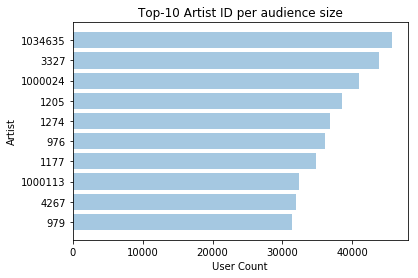

In [76]:

# calculate top-10 artists in term of audience size# calcul 
top10ArtistsUC = (newUserArtistDF.dropDuplicates(['userID', 'artistID'])
                      .groupBy("artistID")
                      .count()
                      .orderBy("count", ascending=0)
                      .take(10)
                  )

y_pos = range(len(top10ArtistsUC))
pdf = pd.DataFrame(data=top10ArtistsUC)

plt.barh(y_pos, pdf[1][::-1], align='center', alpha=0.4)
plt.yticks(range(9,-1,-1), pdf[0][::-1])
plt.xlabel('User Count')
plt.ylabel('Artist')
plt.title('Top-10 Artist ID per audience size')
plt.show()

In [77]:
pdf

,0,1
0,979,45630
1,4267,43883
2,1000113,40919
3,1177,38497
4,976,36823
5,1274,36036
6,1205,34853
7,1000024,32337
8,3327,31951
9,1034635,31324


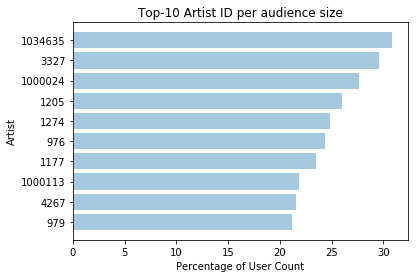

In [78]:
# calculate top-10 artists in term of audience size
plt.barh(y_pos, pdf[1][::-1]/uniqueUsers*100, align='center', alpha=0.4)
plt.yticks(range(9,-1,-1), pdf[0][::-1])
plt.xlabel('Percentage of User Count')
plt.ylabel('Artist')
plt.title('Top-10 Artist ID per audience size')
plt.show()

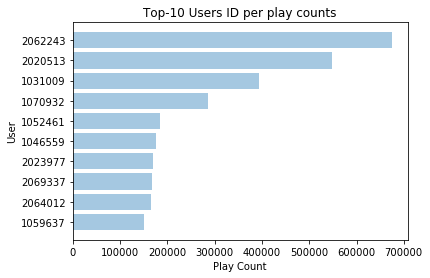

In [79]:
# calculate top 10 users interm of play counts
top10UsersByPlayCount = newUserArtistDF.groupBy("userID").sum("playCount").orderBy('sum(playCount)', ascending=0).take(10)

y_pos = range(len(top10UsersByPlayCount))
pdf = pd.DataFrame(data=top10UsersByPlayCount)

plt.barh(y_pos, pdf[1][::-1], align='center', alpha=0.4)
plt.yticks(range(9,-1,-1), pdf[0][::-1])
plt.xlabel('Play Count')
plt.ylabel('User')
plt.title('Top-10 Users ID per play counts')
plt.show()

In [80]:
pdf

,0,1
0,1059637,674412
1,2064012,548427
2,2069337,393515
3,2023977,285978
4,1046559,183972
5,1052461,175822
6,1070932,168977
7,1031009,167273
8,2020513,165642
9,2062243,151504


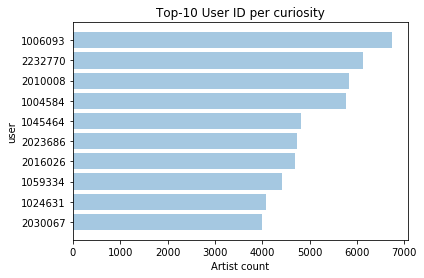

In [81]:

# calculate top 10 users interm of curiosity# calcul 
top10UsersByCuriosity = (newUserArtistDF.dropDuplicates(['userID', 'artistID'])
                          .groupBy("userID")
                          .count()
                          .orderBy("count", ascending=0)
                          .take(10)
                         )

y_pos = range(len(top10UsersByCuriosity))
pdf = pd.DataFrame(data=top10UsersByCuriosity)

plt.barh(y_pos, pdf[1][::-1], align='center', alpha=0.4)
plt.yticks(range(9,-1,-1), pdf[0][::-1])
plt.xlabel('Artist count')
plt.ylabel('user')
plt.title('Top-10 User ID per curiosity')
plt.show()

In [82]:
pdf

,0,1
0,2030067,6735
1,1024631,6125
2,1059334,5839
3,2016026,5773
4,2023686,4822
5,1045464,4734
6,1004584,4690
7,2010008,4411
8,2232770,4090
9,1006093,4005
